In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812363 sha256=b9eddad4c20e811690ea6b81fc4d70806b260c6671db4910bfc86d11892b9f3e
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [4]:
! pip install matplotlib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Silhouette Score:  0.9886614531588208
Silhouette Score:  0.9222692618451699
Silhouette Score:  0.9288941008605686
The best k is: 2 0.9886614531588208


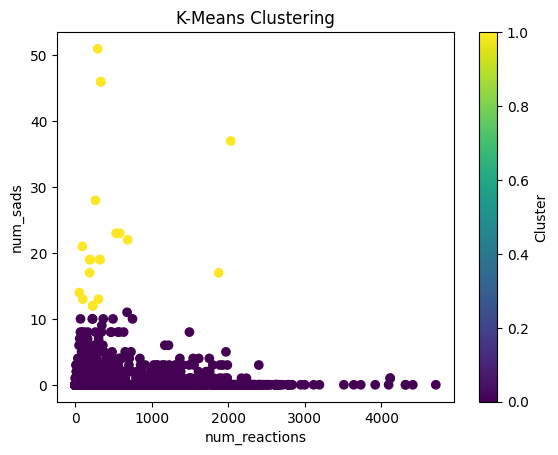

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler , StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import matplotlib.pyplot as plt
import pandas as pd

# Creating the SparkSession
spark = SparkSession.builder.appName("testKMeans").getOrCreate()

df = spark.read.format("csv").option("header",True).load("fb_live_thailand.csv")

df = df.select(df.num_sads.cast(DoubleType()),df.num_reactions.cast(DoubleType()))

# Concatenate input columns to the output "features"
vec_assembler = VectorAssembler(inputCols=["num_sads", "num_reactions"], outputCol="features")

# Scaling for making columns comparable
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Initialise k_values list
k_values = []

# Loop for finding the optimal k in range 2 to 5
for i in range(2, 5):
    kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="prediction", k=i)
    pipeline = Pipeline(stages=[vec_assembler, scaler, kmeans])
    model = pipeline.fit(df)
    output = model.transform(df)
    evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="scaledFeatures", metricName="silhouette", distanceMeasure="squaredEuclidean")

    score = evaluator.evaluate(output)
    k_values.append(score)
    print('Silhouette Score: ',score)

# Get the best K
best_k = k_values.index(max(k_values)) + 2
print("The best k is:", best_k, max(k_values))

# Initialise KMeans
kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="prediction", k=best_k)

# Create pipeline
pipeline = Pipeline(stages=[vec_assembler, scaler, kmeans])

# Fit model
model = pipeline.fit(df)

# Predictions
predictions = model.transform(df)

# Evaluate
evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="scaledFeatures", metricName="silhouette", distanceMeasure="squaredEuclidean")

# Visualizing the results
clustered_data_pd = predictions.toPandas()

plt.scatter(clustered_data_pd["num_reactions"], clustered_data_pd["num_sads"], c=clustered_data_pd["prediction"])
plt.xlabel("num_reactions")
plt.ylabel("num_sads")
plt.title("K-Means Clustering")
plt.colorbar().set_label("Cluster")
plt.show()